# Predicting MPG with SDC

**Author:** Richard Hemphill<br>
**ID:** 903877709<br>
**Class:** ECE5268 Theory of Neural Networks<br>
**Instructor:** Dr. Georgios C. Anagnostopoulos<br>
**Description:** Utilize characteristics from various cars to predict miles-per-gallon fuel consumption.  The prediction equation is determined using Stocastic Gradient Descent minimization method.

In [1387]:
# CONSTANTS
DATASET_FILE = 'autompg_dataset.csv'
NUMBER_FOR_TRAINING = 200
NUMBER_FOR_VALIDATION = 100
OUTPUT_FEATURE='mpg'
INPUT_FEATURES=['horsepower','weight']
FEATURES = [OUTPUT_FEATURE] + INPUT_FEATURES
EPOCHS = 1000
ETA_MAX=1E-6
BETA=0.5
MOMENTUM=0.9
THRESHOLD=1E-4

In [1388]:
# LIBRARIES
import time                         # processing throughput
import math                         # number of batches
import numpy as np                  # matrix manipulation
import random                       # shuffle data
import matplotlib.pyplot as plt     # surface plot

In [1389]:
# FUNCTIONS

# Create Design Matrix
def DesignMatrix(dataSet, features):
    # Create the design matrix.
    dm = dataSet[features[0]]
    for feature in features[1:]:
        dm = np.column_stack((dm,dataSet[feature]))
    return dm.astype(float)

# Create Augmented Design Matrix
def AugmentedDesignMatrix(dataSet, features):
    # Create the design matrix.
    adm = DesignMatrix(dataSet=dataSet, features=features)
     # Augment the design matrix to accomodate the bias term.
    adm = np.column_stack((adm,np.ones(len(adm))))
    return adm.astype(float)

In [1390]:
# Calculate Mean Squared Error
def MSE(actual, predicted):
    return np.square(np.subtract(actual, predicted)).mean()

In [1391]:
# Create a Prediciton Equation String
def PredictionEquation(y, xs, w):
    eq = '{} = '.format(y)
    wfmat = lambda i: ('+' if i > 0 else '') + '{:0.6}'.format(i)
    for idx, x in enumerate(xs):
        eq += '{}*{}'.format(wfmat(w[idx]), x)
    eq += wfmat(w[-1])
    return eq

In [1392]:
def GetBatch(batchSize,trainSet,t):
    # Parse out a sample of the training set for a batch.
    if batchSize > 1:
        batchStart = (batchSize)*(t)
        batchEnd = (batchSize)*(t+1)
        trainLen = len(trainSet)
        if batchEnd >= trainLen:
            # when batch goes over training length, use the last samples and some from the start
            batchWrap = batchEnd - trainLen + 1
            batchEnd = trainLen-1
            batchSet = trainSet[batchStart:batchEnd]
            batchSet = np.append(batchSet,trainSet[0:batchWrap])
        else:
            batchSet = trainSet[batchStart:batchEnd]
    else:
        batchSet = trainSet[t]
    
    return batchSet

In [1393]:
def GetIndex(featureList,feature):
    if len(feature) > 1:
        return range(1,2)
    else:
        return featureList.index(feature)

In [1394]:
# Perform Stochastic Gradient Decent on a Training Set
def StochasticGradientDecent(trainSet, valSet, batchSize=1, outParam=OUTPUT_FEATURE, inParam=INPUT_FEATURES, epochs=EPOCHS,etaMax=ETA_MAX, beta=BETA, m=MOMENTUM, threshold=THRESHOLD):
    # start timer
    tic = time.time()

    # Parse out parameters from training set
    Ytrain = trainSet[outParam]
    Xtrain = DesignMatrix(dataSet=trainSet,features=inParam)

    # Get the mean of the training set
    Ymean = Ytrain.mean(axis=0).astype(float)
    Xmean = Xtrain.mean(axis=0).astype(float)

    # Create and augmented input matrix
    XtrainA = AugmentedDesignMatrix(dataSet=trainSet,features=inParam)

    # Configure validation set.
    Yval = valSet[outParam]
    XvalA = AugmentedDesignMatrix(dataSet=valSet,features=inParam)

    # Inialize the weight vector with zeros.
    Wa = np.zeros(len(inParam)+1).astype(float)
    W = np.zeros(len(inParam)).astype(float)
    dW = np.zeros(len(inParam)).astype(float)

    # Determine the number of itterations needed.
    numBatches = math.ceil(len(trainSet)/batchSize)

    # Collection of results
    trainMse = []
    valMse = []

    # starting itterating from zero
    itteration = 0

    # make a deap copy it avoid affecting the original set during batchshuffle
    procSet = np.copy(trainSet)

    for e in range(epochs):
        # shuffle the processing set
        np.take(procSet,np.random.rand(procSet.shape[0]).argsort(),axis=0,out=procSet)

        for batch in range(numBatches):
            # Parse out a batch of samples
            batchSet = GetBatch(batchSize,procSet,batch)

            # Segregate out the parameter values.
            Ybatch = batchSet[outParam].astype(float)
            Xbatch = DesignMatrix(dataSet=batchSet,features=inParam)

            # Center the batch set
            Ybatch -= Ymean
            Xbatch -= Xmean

            # Gradient of the error.
            g = 2.0 * Xbatch.T.dot(Xbatch.dot(W)-Ybatch) / batchSize

            # Update the learning rate.
            eta = etaMax / (1 + (beta * itteration * batchSize))
            itteration += 1

            # Change in theta
            dW = - eta * g + m * dW

            # Update theta
            W += dW

            # Stop if the magnitude of the change in theta is less than a threshold
            if np.linalg.norm(dW) < threshold:
                break

        Wa[:-1] = W
        Wa[-1] = Ymean - Xmean.T.dot(W)

        # Collect training/validation samples.
        trainMse.append(MSE(Ytrain,XtrainA.dot(Wa)))
        valMse.append(MSE(Yval,XvalA.dot(Wa)))

    # record processing time
    procTime = time.time() - tic

    return Wa, trainMse, valMse, procTime

In [1395]:
def SgdPlot(trainMse,valMse,batchSize):
    plt.plot(trainMse,color='b',label='Training MSE')
    plt.plot(valMse,color='r',label='Validation MSE')
    plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.title('MSE per Epoch for Batch Size of {}'.format(batchSize))
    plt.show()

In [1396]:
# Load data file
csvFile = open(DATASET_FILE, 'r')
dataSet = np.genfromtxt(csvFile, delimiter=',', names=True, case_sensitive=True)
csvFile.close()

In [1397]:
# Split the data set into groups for training, validation and test.
trainData = dataSet[:NUMBER_FOR_TRAINING]
valData = dataSet[NUMBER_FOR_TRAINING+1:NUMBER_FOR_TRAINING+NUMBER_FOR_VALIDATION]
testData = dataSet[NUMBER_FOR_TRAINING+NUMBER_FOR_VALIDATION+1:]

## Part (a): Batch Size 1
Plot the training and validation MSE per epoch for a batch size of 1.

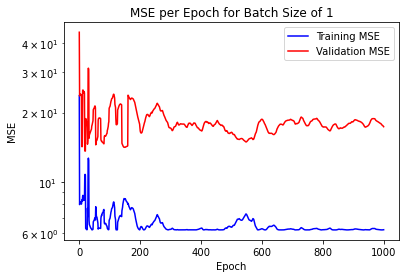

mpg = -0.00509292*horsepower-0.00557383*weight+38.0806
Processing Time: 0.151597 seconds
Last MSE: training(6.19422) validation(17.3652)


In [1398]:
BATCH_SIZE = 1
Wa, trainMse, valMse, procTime = StochasticGradientDecent(trainSet=trainData, valSet=valData,batchSize=BATCH_SIZE,etaMax=ETA_MAX)
SgdPlot(trainMse=trainMse,valMse=valMse,batchSize=BATCH_SIZE)
print(PredictionEquation(y=OUTPUT_FEATURE, xs=INPUT_FEATURES, w=Wa))
print('Processing Time: {:0.6} seconds'.format(procTime))
print('Last MSE: training({:0.6}) validation({:0.6})'.format(trainMse[-1],valMse[-1]))

### Observation
The weights, bias, and MSE are close the the values predicted with OLS.  Thus, proving that SGD is can produce consistent results.  On the other hand, OLS was able to calculate the weights and biases much quicker.  For much larger data set sizes and dimentions, SGD should be quicker.  The training MSE was much lower than the validation MSE due to the weight/bias being optimized specifically for the training set.  The largest max learning rate for SGD that could be used with the defaul beta of 0.5 that could maintain a training MSE under 10 was 3E-6.

## Part (b): Batch Size 20
Same as part a but with batch size of 20.

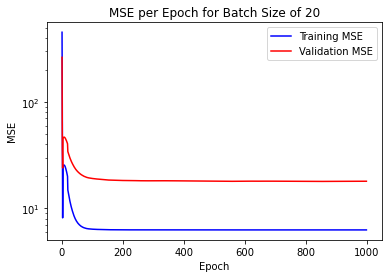

mpg = -0.000451494*horsepower-0.00562758*weight+37.7151
Processing Time: 0.110703 seconds
Last MSE: training(6.25819) validation(17.9644)


In [1399]:
BATCH_SIZE = 20
Wa, trainMse, valMse, procTime = StochasticGradientDecent(trainSet=trainData, valSet=valData,batchSize=BATCH_SIZE,etaMax=ETA_MAX)
SgdPlot(trainMse=trainMse,valMse=valMse,batchSize=BATCH_SIZE)
print(PredictionEquation(y=OUTPUT_FEATURE, xs=INPUT_FEATURES, w=Wa))
print('Processing Time: {:0.6} seconds'.format(procTime))
print('Last MSE: training({:0.6}) validation({:0.6})'.format(trainMse[-1],valMse[-1]))

### Observation
The mini-batch gradient decent produced compariable results to OLD.  The mini-batch was quicker converging to a minimal MSE than SGD. Also, it was slightly faster at calculating theta over the epoch than SGD due to less itterations.  The largest max learning rate for mini-batch that could be used with the defaul beta of 0.5 that could maintain a training MSE under 10 was 2E-5.